In [1]:
import numpy as np
import aipy
import healpy
from scipy.interpolate import RegularGridInterpolator, interp1d
import glob, os
import pandas

import matplotlib.pyplot as plt

In [2]:
#PATHs = ['eigsep_bowtie_v000']
#PATHs = ['eigsep_reflector_bowtie_v000']
#PATHs = glob.glob('Bended_Antenna_Results/Angle_*')
PATHs = ['CoBeam Results_Slotted BowTie over a Simple Box', 'CrossBeam Results_Slotted BowTie over a Simple Box']
print(len(PATHs))
NSIDE = 64

2


In [3]:
def filename_to_frequency(name):
    if name.find('MHz') != -1:
        return float(name.split('_')[-1].split('MHz')[0]) * 1e6
    else:
        return float(name.split('_')[-1].split('Hz')[0])

def read_beam_csv(filename):
    freq = filename_to_frequency(filename)
    pdf = pandas.read_csv(filename)
    phi_col = [name for name in pdf.columns if name.lower().startswith('phi')][0]
    theta_col = [name for name in pdf.columns if name.lower().startswith('theta')][0]
    gain_col = [name for name in pdf.columns if name.lower().find('gain') != -1][0]
    phi = np.deg2rad(np.asarray(pdf[phi_col]))
    theta = np.deg2rad(np.asarray(pdf[theta_col]))
    nphi = np.sum(theta == 0)
    shape = (phi.size // nphi, nphi)
    gain = np.asarray(pdf[gain_col])
    return freq, phi.reshape(shape)[0], theta.reshape(shape)[:,0], gain.reshape(shape)

def read_Z_csv(filename):
    pdf = pandas.read_csv(filename)
    freq_col = [name for name in pdf.columns if name.lower().startswith('freq')][0]
    real_col = [name for name in pdf.columns if name.lower().startswith('re')][0]
    imag_col = [name for name in pdf.columns if name.lower().startswith('im')][0]
    freqs = np.asarray(pdf[freq_col], dtype=float) * 1e6
    Z = np.asarray(pdf[real_col] + 1j*pdf[imag_col], dtype=complex)
    return freqs, Z
    
def read_S11_csv(filename):
    pdf = pandas.read_csv(filename)
    freq_col = [name for name in pdf.columns if name.lower().startswith('freq')][0]
    S11_col = [name for name in pdf.columns if name.lower().startswith('db')][0]
    freqs = np.asarray(pdf[freq_col], dtype=float) * 1e6
    S11 = np.asarray(pdf[S11_col], dtype=float)
    return freqs, 10**(S11 / 10)

In [8]:
for path in PATHs:
    outfile = f'{path.replace("/","_")}.npz'
    if os.path.exists(outfile):
        print(f'Output {outfile} exists. Skipping...')
        continue
    files = sorted(glob.glob(os.path.join(path, 'Freq*.csv')), key=filename_to_frequency)
    npix = healpy.nside2npix(NSIDE)
    lat, lon = healpy.pix2ang(NSIDE, np.arange(npix))
    lon = np.where(lon > np.pi, lon - 2 * np.pi, lon)
    
    freqs = np.empty(len(files), dtype=float)
    beam_data = np.empty((len(files), npix), dtype=np.float32)
    for ch, filename in enumerate(files):
        freqs[ch], phi, theta, gain = read_beam_csv(filename)
        interpolator = RegularGridInterpolator((theta, phi), gain, bounds_error=False, fill_value=None, method='cubic')
        #if ch == 8:
        #    plt.figure()
        #    plt.imshow(gain)
        beam_data[ch] = interpolator((lat, lon))

    print(f'Writing {outfile}')
    np.savez(outfile, freqs=freqs, bm=beam_data, nside=NSIDE)

Output CoBeam Results_Slotted BowTie over a Simple Box.npz exists. Skipping...
Output CrossBeam Results_Slotted BowTie over a Simple Box.npz exists. Skipping...


In [10]:
_freqs, _Z = read_Z_csv(os.path.join(PATH, 'Z_Parameters.csv'))
termination = 75 # Ohm
Z_interp = interp1d(_freqs, _Z, kind='cubic')
Z = Z_interp(freqs)
S11 = (np.abs(Z - termination) / np.abs(Z + termination))**2
#_, _S11 = read_S11_csv(os.path.join(PATH, 'S_Parameter_dB.csv'))
_, _S11 = read_S11_csv(os.path.join(PATH, 'S_Parameter_75.csv'))

np.savez(f'S11_{PATH}.npz', freqs=freqs, Z=Z, S11=S11, termination=termination)

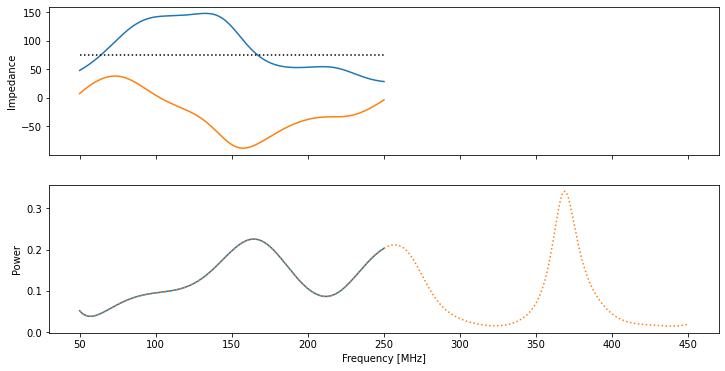

In [14]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
axes[0].plot(freqs / 1e6, Z.real)
axes[0].plot(freqs / 1e6, Z.imag)
axes[0].plot(freqs / 1e6, np.ones_like(Z.real) * termination, 'k:')
axes[0].set_ylabel('Impedance')
axes[1].plot(freqs / 1e6, S11)
axes[1].plot(_freqs / 1e6, _S11, ':')
axes[1].set_ylabel('Power')
_ = axes[1].set_xlabel('Frequency [MHz]')

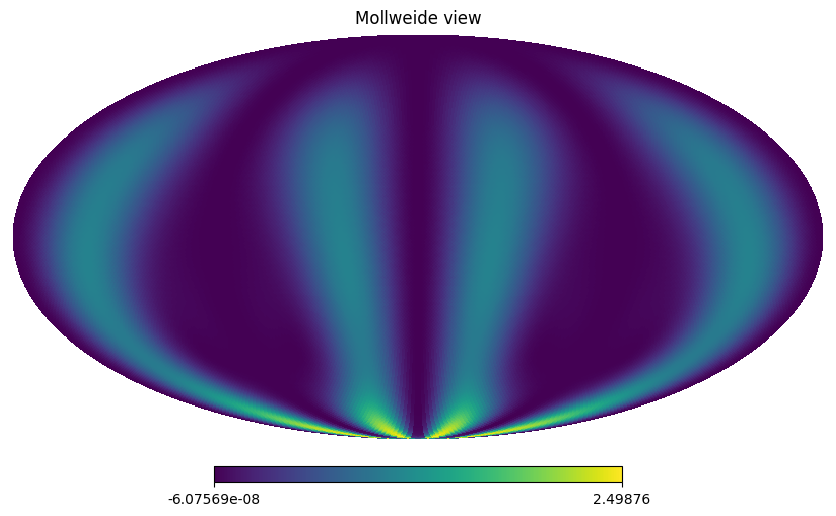

In [18]:
healpy.mollview(beam_data[44])